In [1]:
import matplotlib
import matplotlib.pyplot as plt

from datetime import datetime

from tensorflow import keras
import tensorflow as tf
import numpy as np

from OperatorLayer import SymmetricOperator
from OperatorLayer import SolveOperatorInverse
from NormalizedMeanSquaredError import NormalizedMeanSquaredError as NMSE

In [2]:
data_name = 'Duffing_Equation_expt4'  ## FILL IN HERE (from file name)
data_folder = '../NODE-Operators/data/'

# data is num_steps x num_examples x n
data_train_u = np.load(data_folder + "{}_train1_u.npy".format(data_name))
data_train_f = np.load(data_folder + "{}_train1_f.npy".format(data_name))

# data is num_steps x num_examples x n
data_val_u = np.load(data_folder + "{}_val_u.npy".format(data_name))
data_val_f = np.load(data_folder + "{}_val_f.npy".format(data_name))

# data is num_steps x num_examples x n
data_test_u = np.load(data_folder + "{}_test2_u.npy".format(data_name))
data_test_f = np.load(data_folder + "{}_test2_f.npy".format(data_name))

In [3]:
# commented out name in final model because this was causing the loading issue:
# see https://stackoverflow.com/questions/57201943/during-creating-vae-model-throws-exception-you-should-implement-a-call-method

def construct_encoder(n, l, act_layer_config, lin_layer_config, name):
    # First build the encoder
    input_ = keras.layers.Input(shape=n)
    hidden1 = keras.layers.Dense(n, **act_layer_config)(input_)
    hidden2 = keras.layers.Dense(n, **act_layer_config)(hidden1)
    hidden3 = keras.layers.Dense(n, **lin_layer_config)(hidden2)
    added = keras.layers.Add()([input_, hidden3])
    latentspace = keras.layers.Dense(l, **lin_layer_config)(added)
    encoder = keras.Model(inputs=[input_], outputs=[latentspace], name=name)
    return encoder

def construct_decoder(n, l, act_layer_config, lin_layer_config, name):
    # Now the decoder
    latent_ = keras.layers.Input(shape=l)
    hidden4 = keras.layers.Dense(n, **lin_layer_config)(latent_)
    hidden5 = keras.layers.Dense(n, **act_layer_config)(hidden4)
    hidden6 = keras.layers.Dense(n, **act_layer_config)(hidden5)
    hidden7 = keras.layers.Dense(n, **act_layer_config)(hidden6)
    added_ = keras.layers.Add()([hidden4, hidden7])
    decoder = keras.Model(inputs=[latent_], outputs=[added_], name=name)
    return decoder


In [4]:
_, n = data_train_u.shape
l = 20

print("Training contains:", data_train_u.shape[0], "samples.")
print("Validation contains:", data_val_u.shape[0], "samples.")
print("Input vector is", n, "neurons and latent space is", l, "neurons.")

Training contains: 4798 samples.
Validation contains: 1200 samples.
Input vector is 128 neurons and latent space is 20 neurons.


In [5]:
# Set the configuration to be used for layers with activation functions and linear, non-activated functions
#act_layer = dict(activation="relu", kernel_initializer='he_normal')
act_layer = dict(activation="elu", kernel_initializer='he_normal')
lin_layer = dict(activation=None)

# Encoder and decoder for u
u_enc = construct_encoder(n, l, act_layer, lin_layer, "u_encoder")
u_dec = construct_decoder(n, l, act_layer, lin_layer, "u_decoder")

# Encoder and decoder for u
f_enc = construct_encoder(n, l, act_layer, lin_layer, "f_encoder")
f_dec = construct_decoder(n, l, act_layer, lin_layer, "f_decoder")

In [6]:
# Now assemble the COMPLETE, LINKED autoencoder!!
u_input = keras.layers.Input(shape=n)
u_encoded = u_enc(u_input)

f_input = keras.layers.Input(shape=n)
f_encoded = f_enc(f_input)

Operator = SymmetricOperator()
#L = Operator.get_operator()
OperatorLayer = Operator(u_encoded)

Inverse = SolveOperatorInverse(Operator)
InverseLayer = Inverse(f_encoded)

#L_full = tf.Variable(tf.eye(l), trainable=True, dtype=tf.float32, name="L_full")
#L_upper = tf.linalg.band_part(L_full, 0, -1, name="L_upper")
#L = tf.multiply(0.5,L_upper+tf.transpose(L_upper), name="L")
#OperatorLayer = tf.matmul(u_encoded, L, name="OperatorLayer")

#f_encoded_T = tf.transpose(f_encoded)
#Linvf_T = tf.linalg.solve(L, f_encoded_T, adjoint=True)
#Linvf = tf.transpose(Linvf_T)

#DiffLayer = keras.layers.Subtract()([OperatorLayer, f_encoded])

u_decoded = u_dec(u_encoded)
f_decoded = f_dec(f_encoded)

Lv_decoded = f_dec(OperatorLayer)
Linvf_decoded = u_dec(InverseLayer)

linked_aec = keras.Model(inputs = [u_input, f_input], 
#                         outputs = [u_decoded, f_decoded, Lv_decoded, Linvf_decoded],
                         outputs = [u_decoded, f_decoded, Lv_decoded, Linvf_decoded])
#                         name="linked_autoencoders")

# Add the superposition loss function
f_sums = tf.reshape(f_encoded[None]+f_encoded[:,None], [-1,l])
Lv_sums = tf.reshape(OperatorLayer[None]+OperatorLayer[:,None], [-1,l])
linked_aec.add_loss(NMSE()(f_encoded, OperatorLayer))
linked_aec.add_loss(NMSE()(f_sums, Lv_sums))


In [7]:
# Set the optimizer to be used
#optimizer = keras.optimizers.SGD(lr=0.01)
optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)

# Create a Normalized Mean Squared Error loss function
loss_fns = 4*[NMSE()]

# Compile the model
#linked_aec.compile(loss=["mse","mse", "mse"], optimizer=optimizer)
#linked_aec.compile(loss=[encoder_loss, encoder_loss, encoder_loss, encoder_loss], optimizer=optimizer)
linked_aec.compile(loss=loss_fns, optimizer=optimizer)

In [8]:
u_enc.summary()
u_dec.summary()
f_enc.summary()
f_dec.summary()
linked_aec.summary()

Model: "u_encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          16512       input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          16512       dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 128)          16512       dense_1[0][0]                    
__________________________________________________________________________________________

In [19]:
# Specify training options
# Validation data
val_data = [(data_val_u, data_val_f), 
            (data_val_u, data_val_f, data_val_f)]
val_data = [(data_val_u, data_val_f), 
            (data_val_u, data_val_f, data_val_f, data_val_u)]
# Callback functions
cbs = [keras.callbacks.ModelCheckpoint("dae.tf", save_best_only=True),
       keras.callbacks.EarlyStopping()]
# Other options
fit_options = dict(batch_size = 20, epochs = 500)

In [21]:
%%time
hist = linked_aec.fit(x=[data_train_u, data_train_f], 
                      y=[data_train_u, data_train_f, data_train_f, data_train_u], 
                      validation_data=val_data,
                      #callbacks=cbs,
                      **fit_options)

Train on 4798 samples, validate on 1200 samples
Epoch 1/500
4798/4798 [==============================] - 1s 180us/sample - loss: 6.1132 - u_decoder_loss: 0.7067 - f_decoder_loss: 0.6516 - f_decoder_1_loss: 1.0649 - u_decoder_1_loss: 1.6118 - val_loss: 4.6892 - val_u_decoder_loss: 0.6417 - val_f_decoder_loss: 0.4301 - val_f_decoder_1_loss: 0.7172 - val_u_decoder_1_loss: 1.7438
Epoch 2/500
4798/4798 [==============================] - 1s 180us/sample - loss: 3.9957 - u_decoder_loss: 0.5999 - f_decoder_loss: 0.4135 - f_decoder_1_loss: 0.6525 - u_decoder_1_loss: 1.4599 - val_loss: 5.4096 - val_u_decoder_loss: 0.6073 - val_f_decoder_loss: 0.7425 - val_f_decoder_1_loss: 1.0980 - val_u_decoder_1_loss: 1.8348
Epoch 3/500
4798/4798 [==============================] - 1s 179us/sample - loss: 4.6713 - u_decoder_loss: 0.5998 - f_decoder_loss: 0.5328 - f_decoder_1_loss: 0.8677 - u_decoder_1_loss: 1.4924 - val_loss: 4.1916 - val_u_decoder_loss: 0.5484 - val_f_decoder_loss: 0.3763 - val_f_decoder_1_los

Epoch 26/500
4798/4798 [==============================] - 1s 180us/sample - loss: 2.8592 - u_decoder_loss: 0.2812 - f_decoder_loss: 0.2366 - f_decoder_1_loss: 0.4750 - u_decoder_1_loss: 1.0401 - val_loss: 2.6836 - val_u_decoder_loss: 0.2464 - val_f_decoder_loss: 0.2133 - val_f_decoder_1_loss: 0.6771 - val_u_decoder_1_loss: 0.8155
Epoch 27/500
4798/4798 [==============================] - 1s 180us/sample - loss: 2.4184 - u_decoder_loss: 0.2525 - f_decoder_loss: 0.1903 - f_decoder_1_loss: 0.3742 - u_decoder_1_loss: 0.9873 - val_loss: 2.4365 - val_u_decoder_loss: 0.2192 - val_f_decoder_loss: 0.1574 - val_f_decoder_1_loss: 0.3624 - val_u_decoder_1_loss: 1.1345
Epoch 28/500
4798/4798 [==============================] - 1s 181us/sample - loss: 2.3029 - u_decoder_loss: 0.2411 - f_decoder_loss: 0.1772 - f_decoder_1_loss: 0.3183 - u_decoder_1_loss: 0.9816 - val_loss: 4.0160 - val_u_decoder_loss: 0.2895 - val_f_decoder_loss: 0.2655 - val_f_decoder_1_loss: 0.9758 - val_u_decoder_1_loss: 1.1759
Epoc

Epoch 51/500
4798/4798 [==============================] - 1s 184us/sample - loss: 2.2556 - u_decoder_loss: 0.1720 - f_decoder_loss: 0.1840 - f_decoder_1_loss: 0.4452 - u_decoder_1_loss: 0.7429 - val_loss: 2.5635 - val_u_decoder_loss: 0.2144 - val_f_decoder_loss: 0.1199 - val_f_decoder_1_loss: 0.4180 - val_u_decoder_1_loss: 1.1876
Epoch 52/500
4798/4798 [==============================] - 1s 187us/sample - loss: 1.9126 - u_decoder_loss: 0.2142 - f_decoder_loss: 0.1063 - f_decoder_1_loss: 0.2116 - u_decoder_1_loss: 0.8635 - val_loss: 2.0952 - val_u_decoder_loss: 0.1824 - val_f_decoder_loss: 0.0662 - val_f_decoder_1_loss: 0.2282 - val_u_decoder_1_loss: 1.2357
Epoch 53/500
4798/4798 [==============================] - 1s 191us/sample - loss: 1.9568 - u_decoder_loss: 0.1703 - f_decoder_loss: 0.1267 - f_decoder_1_loss: 0.3614 - u_decoder_1_loss: 0.7985 - val_loss: 2.6688 - val_u_decoder_loss: 0.2061 - val_f_decoder_loss: 0.2081 - val_f_decoder_1_loss: 0.5482 - val_u_decoder_1_loss: 1.1524
Epoc

Epoch 76/500
4798/4798 [==============================] - 1s 180us/sample - loss: 1.6827 - u_decoder_loss: 0.1677 - f_decoder_loss: 0.1259 - f_decoder_1_loss: 0.2286 - u_decoder_1_loss: 0.7653 - val_loss: 1.6731 - val_u_decoder_loss: 0.1786 - val_f_decoder_loss: 0.1210 - val_f_decoder_1_loss: 0.2730 - val_u_decoder_1_loss: 0.7557
Epoch 77/500
4798/4798 [==============================] - 1s 181us/sample - loss: 1.6974 - u_decoder_loss: 0.1706 - f_decoder_loss: 0.1263 - f_decoder_1_loss: 0.2481 - u_decoder_1_loss: 0.7759 - val_loss: 3.1466 - val_u_decoder_loss: 0.5644 - val_f_decoder_loss: 0.1516 - val_f_decoder_1_loss: 0.6344 - val_u_decoder_1_loss: 1.1062
Epoch 78/500
4798/4798 [==============================] - 1s 179us/sample - loss: 1.6867 - u_decoder_loss: 0.1778 - f_decoder_loss: 0.1206 - f_decoder_1_loss: 0.2797 - u_decoder_1_loss: 0.6902 - val_loss: 2.8677 - val_u_decoder_loss: 0.1265 - val_f_decoder_loss: 0.1042 - val_f_decoder_1_loss: 0.6304 - val_u_decoder_1_loss: 0.6728
Epoc

Epoch 101/500
4798/4798 [==============================] - 1s 183us/sample - loss: 2.2392 - u_decoder_loss: 0.1721 - f_decoder_loss: 0.1523 - f_decoder_1_loss: 0.4516 - u_decoder_1_loss: 0.7632 - val_loss: 1.7505 - val_u_decoder_loss: 0.1797 - val_f_decoder_loss: 0.1341 - val_f_decoder_1_loss: 0.3339 - val_u_decoder_1_loss: 0.7651
Epoch 102/500
4798/4798 [==============================] - 1s 184us/sample - loss: 1.2183 - u_decoder_loss: 0.1144 - f_decoder_loss: 0.0821 - f_decoder_1_loss: 0.1606 - u_decoder_1_loss: 0.5939 - val_loss: 1.3176 - val_u_decoder_loss: 0.1389 - val_f_decoder_loss: 0.0703 - val_f_decoder_1_loss: 0.1892 - val_u_decoder_1_loss: 0.6945
Epoch 103/500
4798/4798 [==============================] - 1s 181us/sample - loss: 1.3663 - u_decoder_loss: 0.1404 - f_decoder_loss: 0.0724 - f_decoder_1_loss: 0.1376 - u_decoder_1_loss: 0.7116 - val_loss: 1.4609 - val_u_decoder_loss: 0.1395 - val_f_decoder_loss: 0.0679 - val_f_decoder_1_loss: 0.3249 - val_u_decoder_1_loss: 0.6352
E

Epoch 126/500
4798/4798 [==============================] - 1s 195us/sample - loss: 1.2891 - u_decoder_loss: 0.1120 - f_decoder_loss: 0.0744 - f_decoder_1_loss: 0.1700 - u_decoder_1_loss: 0.6241 - val_loss: 1.8744 - val_u_decoder_loss: 0.1382 - val_f_decoder_loss: 0.0798 - val_f_decoder_1_loss: 0.4290 - val_u_decoder_1_loss: 0.7273
Epoch 127/500
4798/4798 [==============================] - 1s 182us/sample - loss: 1.7414 - u_decoder_loss: 0.1347 - f_decoder_loss: 0.1643 - f_decoder_1_loss: 0.4071 - u_decoder_1_loss: 0.6280 - val_loss: 1.2688 - val_u_decoder_loss: 0.1214 - val_f_decoder_loss: 0.0756 - val_f_decoder_1_loss: 0.2073 - val_u_decoder_1_loss: 0.6007
Epoch 128/500
4798/4798 [==============================] - 1s 181us/sample - loss: 1.2342 - u_decoder_loss: 0.1224 - f_decoder_loss: 0.0916 - f_decoder_1_loss: 0.1766 - u_decoder_1_loss: 0.5736 - val_loss: 1.2131 - val_u_decoder_loss: 0.1267 - val_f_decoder_loss: 0.0541 - val_f_decoder_1_loss: 0.1812 - val_u_decoder_1_loss: 0.6351
E

Epoch 151/500
4798/4798 [==============================] - 1s 183us/sample - loss: 1.2108 - u_decoder_loss: 0.1019 - f_decoder_loss: 0.1285 - f_decoder_1_loss: 0.1718 - u_decoder_1_loss: 0.5742 - val_loss: 1.2926 - val_u_decoder_loss: 0.1362 - val_f_decoder_loss: 0.1566 - val_f_decoder_1_loss: 0.2085 - val_u_decoder_1_loss: 0.5316
Epoch 152/500
4798/4798 [==============================] - 1s 181us/sample - loss: 1.3616 - u_decoder_loss: 0.0964 - f_decoder_loss: 0.1121 - f_decoder_1_loss: 0.2768 - u_decoder_1_loss: 0.4758 - val_loss: 1.2561 - val_u_decoder_loss: 0.1155 - val_f_decoder_loss: 0.0927 - val_f_decoder_1_loss: 0.2157 - val_u_decoder_1_loss: 0.5905
Epoch 153/500
4798/4798 [==============================] - 1s 179us/sample - loss: 1.4083 - u_decoder_loss: 0.1532 - f_decoder_loss: 0.0896 - f_decoder_1_loss: 0.1917 - u_decoder_1_loss: 0.6188 - val_loss: 1.3381 - val_u_decoder_loss: 0.1114 - val_f_decoder_loss: 0.0809 - val_f_decoder_1_loss: 0.2704 - val_u_decoder_1_loss: 0.5457
E

Epoch 176/500
4798/4798 [==============================] - 1s 180us/sample - loss: 1.2123 - u_decoder_loss: 0.0865 - f_decoder_loss: 0.0798 - f_decoder_1_loss: 0.1975 - u_decoder_1_loss: 0.5124 - val_loss: 1.2866 - val_u_decoder_loss: 0.1115 - val_f_decoder_loss: 0.0611 - val_f_decoder_1_loss: 0.2786 - val_u_decoder_1_loss: 0.5720
Epoch 177/500
4798/4798 [==============================] - 1s 181us/sample - loss: 1.5298 - u_decoder_loss: 0.1220 - f_decoder_loss: 0.1272 - f_decoder_1_loss: 0.2824 - u_decoder_1_loss: 0.5563 - val_loss: 1.8533 - val_u_decoder_loss: 0.2816 - val_f_decoder_loss: 0.0933 - val_f_decoder_1_loss: 0.2510 - val_u_decoder_1_loss: 0.7859
Epoch 178/500
4798/4798 [==============================] - 1s 180us/sample - loss: 1.0478 - u_decoder_loss: 0.1049 - f_decoder_loss: 0.0515 - f_decoder_1_loss: 0.1385 - u_decoder_1_loss: 0.5185 - val_loss: 1.2107 - val_u_decoder_loss: 0.1285 - val_f_decoder_loss: 0.0837 - val_f_decoder_1_loss: 0.2099 - val_u_decoder_1_loss: 0.5619
E

Epoch 201/500
4798/4798 [==============================] - 1s 178us/sample - loss: 1.1251 - u_decoder_loss: 0.1033 - f_decoder_loss: 0.0926 - f_decoder_1_loss: 0.1840 - u_decoder_1_loss: 0.4873 - val_loss: 1.2147 - val_u_decoder_loss: 0.1037 - val_f_decoder_loss: 0.0714 - val_f_decoder_1_loss: 0.2472 - val_u_decoder_1_loss: 0.4979
Epoch 202/500
4798/4798 [==============================] - 1s 182us/sample - loss: 1.1065 - u_decoder_loss: 0.0904 - f_decoder_loss: 0.0664 - f_decoder_1_loss: 0.1170 - u_decoder_1_loss: 0.5923 - val_loss: 1.0732 - val_u_decoder_loss: 0.1200 - val_f_decoder_loss: 0.0655 - val_f_decoder_1_loss: 0.1707 - val_u_decoder_1_loss: 0.5338
Epoch 203/500
4798/4798 [==============================] - 1s 182us/sample - loss: 0.9163 - u_decoder_loss: 0.0777 - f_decoder_loss: 0.0628 - f_decoder_1_loss: 0.0956 - u_decoder_1_loss: 0.4808 - val_loss: 0.9732 - val_u_decoder_loss: 0.0753 - val_f_decoder_loss: 0.0309 - val_f_decoder_1_loss: 0.1353 - val_u_decoder_1_loss: 0.5313
E

Epoch 226/500
4798/4798 [==============================] - 1s 178us/sample - loss: 1.1567 - u_decoder_loss: 0.0980 - f_decoder_loss: 0.0702 - f_decoder_1_loss: 0.1594 - u_decoder_1_loss: 0.5703 - val_loss: 1.4676 - val_u_decoder_loss: 0.1081 - val_f_decoder_loss: 0.1157 - val_f_decoder_1_loss: 0.2350 - val_u_decoder_1_loss: 0.6677
Epoch 227/500
4798/4798 [==============================] - 1s 178us/sample - loss: 1.0372 - u_decoder_loss: 0.0895 - f_decoder_loss: 0.0672 - f_decoder_1_loss: 0.1308 - u_decoder_1_loss: 0.5402 - val_loss: 2.2992 - val_u_decoder_loss: 0.1394 - val_f_decoder_loss: 0.0554 - val_f_decoder_1_loss: 0.1885 - val_u_decoder_1_loss: 1.5142
Epoch 228/500
4798/4798 [==============================] - 1s 179us/sample - loss: 0.9641 - u_decoder_loss: 0.0786 - f_decoder_loss: 0.0615 - f_decoder_1_loss: 0.1353 - u_decoder_1_loss: 0.4965 - val_loss: 1.2568 - val_u_decoder_loss: 0.1419 - val_f_decoder_loss: 0.0979 - val_f_decoder_1_loss: 0.2565 - val_u_decoder_1_loss: 0.5794
E

Epoch 251/500
4798/4798 [==============================] - 1s 191us/sample - loss: 1.1285 - u_decoder_loss: 0.0870 - f_decoder_loss: 0.0997 - f_decoder_1_loss: 0.2152 - u_decoder_1_loss: 0.4425 - val_loss: 1.0154 - val_u_decoder_loss: 0.1021 - val_f_decoder_loss: 0.0485 - val_f_decoder_1_loss: 0.1934 - val_u_decoder_1_loss: 0.5105
Epoch 252/500
4798/4798 [==============================] - 1s 189us/sample - loss: 0.7122 - u_decoder_loss: 0.0611 - f_decoder_loss: 0.0338 - f_decoder_1_loss: 0.0728 - u_decoder_1_loss: 0.4059 - val_loss: 1.0673 - val_u_decoder_loss: 0.1174 - val_f_decoder_loss: 0.0308 - val_f_decoder_1_loss: 0.1244 - val_u_decoder_1_loss: 0.6470
Epoch 253/500
4798/4798 [==============================] - 1s 190us/sample - loss: 0.7709 - u_decoder_loss: 0.0650 - f_decoder_loss: 0.0488 - f_decoder_1_loss: 0.0951 - u_decoder_1_loss: 0.4214 - val_loss: 1.0886 - val_u_decoder_loss: 0.0990 - val_f_decoder_loss: 0.1208 - val_f_decoder_1_loss: 0.2418 - val_u_decoder_1_loss: 0.4684
E

Epoch 276/500
4798/4798 [==============================] - 1s 182us/sample - loss: 1.0580 - u_decoder_loss: 0.0803 - f_decoder_loss: 0.0813 - f_decoder_1_loss: 0.1763 - u_decoder_1_loss: 0.4079 - val_loss: 1.0441 - val_u_decoder_loss: 0.0896 - val_f_decoder_loss: 0.0465 - val_f_decoder_1_loss: 0.2025 - val_u_decoder_1_loss: 0.5239
Epoch 277/500
4798/4798 [==============================] - 1s 182us/sample - loss: 0.6953 - u_decoder_loss: 0.0693 - f_decoder_loss: 0.0335 - f_decoder_1_loss: 0.0691 - u_decoder_1_loss: 0.3776 - val_loss: 1.0016 - val_u_decoder_loss: 0.0946 - val_f_decoder_loss: 0.0465 - val_f_decoder_1_loss: 0.2069 - val_u_decoder_1_loss: 0.4889
Epoch 278/500
4798/4798 [==============================] - 1s 183us/sample - loss: 0.6416 - u_decoder_loss: 0.0568 - f_decoder_loss: 0.0352 - f_decoder_1_loss: 0.0638 - u_decoder_1_loss: 0.3818 - val_loss: 0.9028 - val_u_decoder_loss: 0.0852 - val_f_decoder_loss: 0.0265 - val_f_decoder_1_loss: 0.1503 - val_u_decoder_1_loss: 0.4927
E

Epoch 301/500
4798/4798 [==============================] - 1s 179us/sample - loss: 0.8284 - u_decoder_loss: 0.0740 - f_decoder_loss: 0.0743 - f_decoder_1_loss: 0.1024 - u_decoder_1_loss: 0.3973 - val_loss: 0.8593 - val_u_decoder_loss: 0.0803 - val_f_decoder_loss: 0.0314 - val_f_decoder_1_loss: 0.1383 - val_u_decoder_1_loss: 0.4681
Epoch 302/500
4798/4798 [==============================] - 1s 178us/sample - loss: 0.8743 - u_decoder_loss: 0.0871 - f_decoder_loss: 0.0477 - f_decoder_1_loss: 0.0919 - u_decoder_1_loss: 0.4910 - val_loss: 0.9893 - val_u_decoder_loss: 0.1187 - val_f_decoder_loss: 0.0514 - val_f_decoder_1_loss: 0.1756 - val_u_decoder_1_loss: 0.4634
Epoch 303/500
4798/4798 [==============================] - 1s 178us/sample - loss: 0.8578 - u_decoder_loss: 0.0785 - f_decoder_loss: 0.0457 - f_decoder_1_loss: 0.1051 - u_decoder_1_loss: 0.4679 - val_loss: 0.8886 - val_u_decoder_loss: 0.1089 - val_f_decoder_loss: 0.0299 - val_f_decoder_1_loss: 0.1170 - val_u_decoder_1_loss: 0.5029
E

Epoch 326/500
4798/4798 [==============================] - 1s 183us/sample - loss: 0.8708 - u_decoder_loss: 0.0763 - f_decoder_loss: 0.0494 - f_decoder_1_loss: 0.1063 - u_decoder_1_loss: 0.4707 - val_loss: 1.1741 - val_u_decoder_loss: 0.0737 - val_f_decoder_loss: 0.0459 - val_f_decoder_1_loss: 0.1860 - val_u_decoder_1_loss: 0.6978
Epoch 327/500
4798/4798 [==============================] - 1s 180us/sample - loss: 0.8305 - u_decoder_loss: 0.0796 - f_decoder_loss: 0.0396 - f_decoder_1_loss: 0.0837 - u_decoder_1_loss: 0.4726 - val_loss: 0.9825 - val_u_decoder_loss: 0.0786 - val_f_decoder_loss: 0.0473 - val_f_decoder_1_loss: 0.1052 - val_u_decoder_1_loss: 0.5994
Epoch 328/500
4798/4798 [==============================] - 1s 180us/sample - loss: 0.7342 - u_decoder_loss: 0.0588 - f_decoder_loss: 0.0482 - f_decoder_1_loss: 0.0973 - u_decoder_1_loss: 0.4128 - val_loss: 1.2968 - val_u_decoder_loss: 0.0737 - val_f_decoder_loss: 0.0838 - val_f_decoder_1_loss: 0.2051 - val_u_decoder_1_loss: 0.7153
E

Epoch 351/500
4798/4798 [==============================] - 1s 182us/sample - loss: 0.8307 - u_decoder_loss: 0.0831 - f_decoder_loss: 0.0397 - f_decoder_1_loss: 0.0943 - u_decoder_1_loss: 0.4442 - val_loss: 0.8855 - val_u_decoder_loss: 0.0668 - val_f_decoder_loss: 0.0803 - val_f_decoder_1_loss: 0.1912 - val_u_decoder_1_loss: 0.4087
Epoch 352/500
4798/4798 [==============================] - 1s 180us/sample - loss: 0.7821 - u_decoder_loss: 0.0569 - f_decoder_loss: 0.0652 - f_decoder_1_loss: 0.1304 - u_decoder_1_loss: 0.3865 - val_loss: 0.9447 - val_u_decoder_loss: 0.0607 - val_f_decoder_loss: 0.0581 - val_f_decoder_1_loss: 0.1506 - val_u_decoder_1_loss: 0.4969
Epoch 353/500
4798/4798 [==============================] - 1s 180us/sample - loss: 0.7607 - u_decoder_loss: 0.0696 - f_decoder_loss: 0.0459 - f_decoder_1_loss: 0.0866 - u_decoder_1_loss: 0.4129 - val_loss: 0.9498 - val_u_decoder_loss: 0.0875 - val_f_decoder_loss: 0.0472 - val_f_decoder_1_loss: 0.1790 - val_u_decoder_1_loss: 0.4797
E

Epoch 376/500
4798/4798 [==============================] - 1s 180us/sample - loss: 0.8024 - u_decoder_loss: 0.0700 - f_decoder_loss: 0.0413 - f_decoder_1_loss: 0.0772 - u_decoder_1_loss: 0.4627 - val_loss: 1.0443 - val_u_decoder_loss: 0.0792 - val_f_decoder_loss: 0.0354 - val_f_decoder_1_loss: 0.2079 - val_u_decoder_1_loss: 0.5210
Epoch 377/500
4798/4798 [==============================] - 1s 181us/sample - loss: 0.8766 - u_decoder_loss: 0.0771 - f_decoder_loss: 0.0601 - f_decoder_1_loss: 0.1126 - u_decoder_1_loss: 0.4685 - val_loss: 1.1755 - val_u_decoder_loss: 0.0823 - val_f_decoder_loss: 0.0817 - val_f_decoder_1_loss: 0.2218 - val_u_decoder_1_loss: 0.5104
Epoch 378/500
4798/4798 [==============================] - 1s 181us/sample - loss: 0.7197 - u_decoder_loss: 0.0693 - f_decoder_loss: 0.0384 - f_decoder_1_loss: 0.0957 - u_decoder_1_loss: 0.3612 - val_loss: 1.0685 - val_u_decoder_loss: 0.0801 - val_f_decoder_loss: 0.0521 - val_f_decoder_1_loss: 0.2228 - val_u_decoder_1_loss: 0.4561
E

Epoch 401/500
4798/4798 [==============================] - 1s 181us/sample - loss: 0.7417 - u_decoder_loss: 0.0751 - f_decoder_loss: 0.0405 - f_decoder_1_loss: 0.0941 - u_decoder_1_loss: 0.3973 - val_loss: 1.1593 - val_u_decoder_loss: 0.1187 - val_f_decoder_loss: 0.0530 - val_f_decoder_1_loss: 0.1563 - val_u_decoder_1_loss: 0.6354
Epoch 402/500
4798/4798 [==============================] - 1s 179us/sample - loss: 0.9289 - u_decoder_loss: 0.0757 - f_decoder_loss: 0.0993 - f_decoder_1_loss: 0.1984 - u_decoder_1_loss: 0.3649 - val_loss: 1.1584 - val_u_decoder_loss: 0.0773 - val_f_decoder_loss: 0.0589 - val_f_decoder_1_loss: 0.2986 - val_u_decoder_1_loss: 0.4929
Epoch 403/500
4798/4798 [==============================] - 1s 178us/sample - loss: 0.7335 - u_decoder_loss: 0.0613 - f_decoder_loss: 0.0353 - f_decoder_1_loss: 0.0846 - u_decoder_1_loss: 0.4246 - val_loss: 0.8851 - val_u_decoder_loss: 0.0939 - val_f_decoder_loss: 0.0331 - val_f_decoder_1_loss: 0.1228 - val_u_decoder_1_loss: 0.5037
E

Epoch 426/500
4798/4798 [==============================] - 1s 180us/sample - loss: 0.8211 - u_decoder_loss: 0.0818 - f_decoder_loss: 0.0622 - f_decoder_1_loss: 0.1107 - u_decoder_1_loss: 0.4328 - val_loss: 1.0667 - val_u_decoder_loss: 0.0962 - val_f_decoder_loss: 0.0531 - val_f_decoder_1_loss: 0.1964 - val_u_decoder_1_loss: 0.5191
Epoch 427/500
4798/4798 [==============================] - 1s 179us/sample - loss: 0.8456 - u_decoder_loss: 0.0865 - f_decoder_loss: 0.0532 - f_decoder_1_loss: 0.1062 - u_decoder_1_loss: 0.4395 - val_loss: 0.7939 - val_u_decoder_loss: 0.0629 - val_f_decoder_loss: 0.0424 - val_f_decoder_1_loss: 0.1527 - val_u_decoder_1_loss: 0.4095
Epoch 428/500
4798/4798 [==============================] - 1s 178us/sample - loss: 0.7333 - u_decoder_loss: 0.0747 - f_decoder_loss: 0.0367 - f_decoder_1_loss: 0.0774 - u_decoder_1_loss: 0.4149 - val_loss: 0.9545 - val_u_decoder_loss: 0.1067 - val_f_decoder_loss: 0.0385 - val_f_decoder_1_loss: 0.1666 - val_u_decoder_1_loss: 0.4954
E

Epoch 451/500
4798/4798 [==============================] - 1s 178us/sample - loss: 0.6679 - u_decoder_loss: 0.0538 - f_decoder_loss: 0.0358 - f_decoder_1_loss: 0.0928 - u_decoder_1_loss: 0.3371 - val_loss: 1.2232 - val_u_decoder_loss: 0.1075 - val_f_decoder_loss: 0.0421 - val_f_decoder_1_loss: 0.1650 - val_u_decoder_1_loss: 0.7415
Epoch 452/500
4798/4798 [==============================] - 1s 180us/sample - loss: 0.8667 - u_decoder_loss: 0.0666 - f_decoder_loss: 0.0598 - f_decoder_1_loss: 0.1307 - u_decoder_1_loss: 0.4585 - val_loss: 1.0486 - val_u_decoder_loss: 0.0732 - val_f_decoder_loss: 0.0454 - val_f_decoder_1_loss: 0.1595 - val_u_decoder_1_loss: 0.6176
Epoch 453/500
4798/4798 [==============================] - 1s 178us/sample - loss: 0.8089 - u_decoder_loss: 0.0701 - f_decoder_loss: 0.0436 - f_decoder_1_loss: 0.1048 - u_decoder_1_loss: 0.4439 - val_loss: 0.9473 - val_u_decoder_loss: 0.1217 - val_f_decoder_loss: 0.0402 - val_f_decoder_1_loss: 0.1705 - val_u_decoder_1_loss: 0.4819
E

Epoch 476/500
4798/4798 [==============================] - 1s 178us/sample - loss: 0.7023 - u_decoder_loss: 0.0628 - f_decoder_loss: 0.0320 - f_decoder_1_loss: 0.0800 - u_decoder_1_loss: 0.4010 - val_loss: 1.3102 - val_u_decoder_loss: 0.1125 - val_f_decoder_loss: 0.0425 - val_f_decoder_1_loss: 0.3948 - val_u_decoder_1_loss: 0.5103
Epoch 477/500
4798/4798 [==============================] - 1s 180us/sample - loss: 1.0498 - u_decoder_loss: 0.0753 - f_decoder_loss: 0.0920 - f_decoder_1_loss: 0.2341 - u_decoder_1_loss: 0.3705 - val_loss: 2.6132 - val_u_decoder_loss: 0.0982 - val_f_decoder_loss: 0.3283 - val_f_decoder_1_loss: 1.1210 - val_u_decoder_1_loss: 0.6295
Epoch 478/500
4798/4798 [==============================] - 1s 182us/sample - loss: 0.8667 - u_decoder_loss: 0.0675 - f_decoder_loss: 0.0824 - f_decoder_1_loss: 0.1497 - u_decoder_1_loss: 0.4059 - val_loss: 1.0102 - val_u_decoder_loss: 0.0884 - val_f_decoder_loss: 0.0580 - val_f_decoder_1_loss: 0.1466 - val_u_decoder_1_loss: 0.5355
E

CPU times: user 16min 31s, sys: 5min 44s, total: 22min 15s
Wall time: 7min 14s


In [11]:
#keras.models.save_model(linked_aec, "dae.tf")

In [12]:
#custom_objects={"NormalizedMeanSquaredError": NMSE,
#                "SymmetricOperator": SymmetricOperator,
#                "Identity": tf.keras.initializers.Identity}
#loaded = keras.models.load_model("dae.tf", custom_objects)
#test_aec = keras.models.load_model("dae-test")

#tf.saved_model.save(linked_aec, "dae-test")
#test_aec = tf.saved_model.load("dae-test")

In [24]:
# Save JSON config (architecture) to disk
model_json = linked_aec.to_json()
with open('model_config.json', 'w') as json_file:
    json_file.write(model_json)

# Save the weights to disk
linked_aec.save_weights("weights.tf")

In [14]:
#linked_aec.layers[1].layers[3].variables[0]

In [22]:
u_aec, f_aec, f_pred, u_pred = linked_aec.predict(x=[data_train_u, data_train_f])

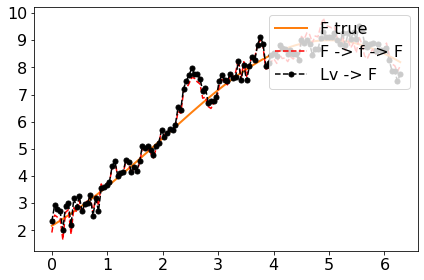

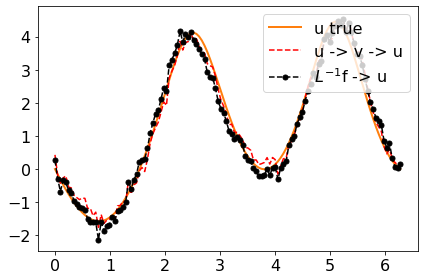

In [23]:
import matplotlib.pyplot as plt

ind = 0
x_pts = np.linspace(0,2*np.pi,n)

plt.figure() 

plt.plot(x_pts, data_train_f[ind,:], 'C1', linewidth=2, label="F true")
plt.plot(x_pts, f_aec[ind,:], '--r', markersize=2, label="F -> f -> F")
plt.plot(x_pts, f_pred[ind,:], 'o--k', markersize=5, label="Lv -> F")

plt.legend(loc="upper right",fontsize=16)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()


plt.figure() 

plt.plot(x_pts, data_train_u[ind,:], 'C1', linewidth=2, label="u true")
plt.plot(x_pts, u_aec[ind,:], '--r', markersize=2, label="u -> v -> u")
plt.plot(x_pts, u_pred[ind,:], 'o--k', markersize=5, label=r"$L^{-1}$f -> u")

plt.legend(loc="upper right",fontsize=16)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()

plt.show()